In [1]:
!pip install gurobipy 

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
# set the max columns to none
pd.set_option('display.max_columns', None)
# set the max rows to none
pd.set_option('display.max_rows', None)

## Defining Helper Functions 

In [2]:
def filling_null_values(df):
    '''2023data.csv has some null values in the 'NDX' column. 
    This function fills those null values with actual values from yahoo finance.
    Also it replaces the null values in the 'ARM' column with 0 for rows where 'Date' is less than 2023-09-14 since it was not listed before that date.
    '''
    #replacing the null values in the data with actual values from web
    #replacing the null values in the data with actual values from web
    stock_price_correction_list = [('2023-03-10',11830.28),('2023-06-12',14784.30),('2023-06-14',15005.69),('2023-06-21',14867.45),('2023-07-06',15089.45),('2023-11-22',16001.39)]
    for correction_date,correction_price in stock_price_correction_list:
        df.loc[df['Date'] == correction_date, 'NDX'] = correction_price

    # Ensure the 'Date' column is in datetime format for accurate comparisons
    # stocks_2023_raw['Date'] = pd.to_datetime(stocks_2023_raw['Date'])

    # Fill NaNs in 'ARM' column with 0 for rows where 'Date' is less than 2023-09-14 since it was not listed before that date
    df.loc[df['Date'] < '2023-09-14', 'ARM'] = df.loc[df['Date'] < '2023-09-14', 'ARM'].fillna(0)
    return df

In [3]:
def interpolate_values(df):
    """
    Interpolate missing values in a dataframe using linear interpolation and handles nulls/infs.
    """
    df_interpolated = df.interpolate(method='linear', limit_direction='both')
    if df_interpolated.isnull().values.any():
        df_interpolated = df_interpolated.fillna(method='ffill').fillna(method='bfill')
    return df_interpolated

In [4]:
def get_return_matrix(df):
    '''gets daily returns of the stocks in the dataframe and replaces inf values with 0'''
    returns_df = df.copy()  # Create a copy of the original DataFrame
    returns_df.drop(columns=['Date'], inplace=True)  # Drop the 'Date' column

    # Calculate daily returns
    returns_df = returns_df.pct_change().fillna(0)
    returns_df.replace([np.inf, -np.inf], 0, inplace=True)
    return returns_df

In [5]:
def get_correlation_df(df):
    '''
    This function takes in a dataframe and returns a Pearson correlation matrix of the features.
    '''
    df = df.drop(columns=['NDX']).corr()
    return df

## Data Pre-processing

In [6]:
# reading out-of-sample data in a dataframe
stocks_2024 = pd.read_csv(r"2024data.csv")

#reading and prepping the data for 2023 in a dataframe
stocks_2023 = filling_null_values(pd.read_csv(r"2023data.csv"))

#handlng null values via interpolation
stocks_2023 = interpolate_values(stocks_2023)


# Number of days in 2023 for which the stock market was active
days_2023 = stocks_2023.shape[0]
print('\n Number of days in 2023 for which the stock market was active:',days_2023)

# Number of stocks in the 2023 dataset (First two columns removed as they are the 'Date' and 'Index')
n = stocks_2023.shape[1] - 2
print('\n Number of stocks in the 2023 dataset:',n)

# View the data
display(stocks_2023.head())
display(stocks_2024.head())


 Number of days in 2023 for which the stock market was active: 250

 Number of stocks in the 2023 dataset: 100


/var/folders/z_/pyggm69d0rnbpbpsfrrvw4m80000gn/T/ipykernel_7369/1533619127.py:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_interpolated = df.interpolate(method='linear', limit_direction='both')


,Date,NDX,ADBE,AMD,ABNB,GOOGL,AMZN,AEP,AMGN,ADI,ANSS,AAPL,AMAT,ARM,ASML,AZN,TEAM,ADSK,ADP,BKR,BIIB,BKNG,AVGO,CDNS,CDW,CHTR,CTAS,CSCO,CCEP,CTSH,CMCSA,CEG,CPRT,CSGP,COST,CRWD,CSX,DDOG,DXCM,FANG,DLTR,DASH,EA,EXC,FAST,FTNT,GEHC,GILD,GFS,HON,IDXX,ILMN,INTC,INTU,ISRG,KDP,KLAC,KHC,LRCX,LIN,LULU,MAR,MRVL,MELI,META,MCHP,MU,MSFT,MRNA,MDLZ,MDB,MNST,NFLX,NVDA,NXPI,ORLY,ODFL,ON,PCAR,PANW,PAYX,PYPL,PDD,PEP,QCOM,REGN,ROP,ROST,SBUX,SMCI,SNPS,TTWO,TMUS,TSLA,TXN,TTD,VRSK,VRTX,WBD,WDAY,XEL,ZS
0,2023-01-03,10862.639648,336.920013,64.019997,84.900002,88.899872,85.820000,88.443291,247.431015,157.418793,238.639999,123.904633,95.322708,0.0,541.091370,66.456459,126.500000,185.149994,228.564468,27.508854,272.630005,2017.688477,53.540184,159.639999,175.963486,341.579987,107.981148,45.047878,52.109909,55.919807,33.807648,80.492386,30.730000,77.650002,437.897552,103.279999,30.132620,72.089996,114.730003,119.767990,140.259995,48.360001,121.550995,40.394791,45.134975,48.520000,55.870144,79.650398,51.700001,206.297150,406.010010,195.398834,25.775146,386.039581,265.630005,33.792770,369.780518,37.691875,38.968071,311.163727,323.380005,145.093506,35.703842,826.109985,124.365547,66.715729,49.875385,236.183533,178.990005,63.550877,190.750000,50.660000,294.950012,14.305581,150.005356,840.719971,140.082916,61.610001,62.115162,138.449997,109.791054,74.580002,84.529999,170.430649,102.922836,720.469971,429.489166,113.620979,96.842880,8.386,319.679993,103.110001,136.915024,108.099998,154.873657,44.020000,175.435257,286.019989,9.54,169.350006,65.785973,110.190002
1,2023-01-04,10914.799805,341.410004,64.660004,88.720001,87.862434,85.139999,89.049248,250.022141,160.771652,242.940002,125.182610,97.865189,0.0,562.023376,66.619408,126.400002,187.960007,229.641602,26.685980,270.809998,2095.359375,54.194099,159.229996,177.571060,354.000000,106.740173,45.038410,53.356094,56.376179,34.777111,81.966423,30.990000,78.000000,441.066223,104.364998,30.522943,68.959999,114.330002,119.075142,140.520004,48.930000,123.738510,40.928265,45.677719,48.299999,60.349739,79.753006,52.910000,202.196228,422.429993,197.091446,26.691210,386.424530,270.000000,34.068432,373.394409,38.117043,39.735584,309.619385,320.980011,147.165558,36.318909,837.440002,126.987656,68.347420,53.667774,225.852081,177.360001,64.011330,187.210007,51.075001,309.410004,14.739296,152.820633,826.739990,143.191818,62.200001,61.976341,138.539993,110.985565,77.690002,91.059998,170.012665,107.080055,726.489990,437.674408,115.720169,100.329338,8.225,320.929993,106.769997,137.820984,113.639999,160.529236,44.310001,178.313995,286.829987,10.38,171.220001,66.349274,111.589996
2,2023-01-05,10741.219727,328.440002,62.330002,87.709999,85.987083,83.120003,87.427124,252.357880,154.744293,231.649994,123.855103,96.495399,0.0,556.598267,66.916557,119.970001,182.070007,224.688705,27.556694,271.589996,2129.612793,53.689156,156.800003,174.542130,361.429993,104.263046,44.403797,53.605331,55.900394,35.147785,80.983742,30.275000,74.900002,434.912384,94.889999,30.161898,63.500000,111.690002,122.192879,142.559998,47.130001,123.411865,40.039131,44.087524,47.450001,58.863194,80.079483,51.020000,196.834259,419.200012,195.671204,26.575499,370.684082,268.619995,33.733875,366.755920,38.200230,39.227673,298.594025,325.929993,146.203186,34.460732,856.090027,126.558952,66.715729,54.172768,219.158371,173.509995,63.493324,172.179993,50.189999,309.700012,14.255615,148.515427,834.289978,139.567291,59.740002,61.704975,135.110001,108.416412,76.269997,95.430000,168.236267,105.035049,723.760010,430.932434,116.141975,100.300529,8.025,315.040009,105.959999,142.271896,110.339996,158.403641,42.590000,175.732025,287.890015,10.86,160.190002,65.006706,104.389999
3,2023-01-06,11040.349609,332.750000,63.959999,88.519997,87.124260,86.080002,89.990829,260.244659,160.393723,239.410004,128.412247,102.753014,0.0,586.657227,67.865524,121.279999,187.190002,230.968796,28.666616,279.250000,2163.677734,56.921028,159.660004,179.600189,367.730011,106.285652,45.767742,54.477669,58.017170,

,Date,NDX,ADBE,AMD,ABNB,GOOGL,AMZN,AEP,AMGN,ADI,ANSS,AAPL,AMAT,ARM,ASML,AZN,TEAM,ADSK,ADP,BKR,BIIB,BKNG,AVGO,CDNS,CDW,CHTR,CTAS,CSCO,CCEP,CTSH,CMCSA,CEG,CPRT,CSGP,COST,CRWD,CSX,DDOG,DXCM,FANG,DLTR,DASH,EA,EXC,FAST,FTNT,GEHC,GILD,GFS,HON,IDXX,ILMN,INTC,INTU,ISRG,KDP,KLAC,KHC,LRCX,LIN,LULU,MAR,MRVL,MELI,META,MCHP,MU,MSFT,MRNA,MDLZ,MDB,MNST,NFLX,NVDA,NXPI,ORLY,ODFL,ON,PCAR,PANW,PAYX,PYPL,PDD,PEP,QCOM,REGN,ROP,ROST,SBUX,SMCI,SNPS,TTWO,TMUS,TSLA,TXN,TTD,VRSK,VRTX,WBD,WDAY,XEL,ZS
0,2024-01-02,16543.939453,580.070007,138.580002,134.479996,137.828705,149.929993,80.703568,290.976105,191.156937,353.000000,184.938217,153.534134,68.919998,712.861511,66.953392,226.669998,234.119995,229.588882,33.259636,267.709991,3455.688965,107.382446,262.899994,218.947250,391.510010,146.154114,48.917702,65.775536,73.506439,42.677998,114.634865,47.509998,85.459999,647.731689,246.889999,34.264618,115.080002,123.089996,151.062332,142.539993,96.459999,135.231522,35.363380,62.471527,57.779999,76.284805,80.644104,58.000000,205.637604,547.690002,133.861862,47.168282,600.172241,330.980011,32.510033,556.992798,36.831211,70.964600,405.871948,505.380005,220.147827,58.011429,1529.160034,345.250519,85.220177,82.096268,368.854095,112.500000,72.461678,383.690002,58.590000,468.500000,48.157665,218.478271,944.979980,198.073471,81.449997,95.952332,288.920013,115.147926,61.459999,145.639999,168.971313,138.237488,905.000000,531.535889,136.652115,91.853561,28.545000,498.970001,159.259995,160.131500,248.419998,165.654648,70.589996,236.890350,410.910004,11.66,268.279999,61.628193,212.369995
1,2024-01-03,16368.490234,571.789978,135.320007,133.419998,138.576859,148.470001,80.897614,294.204926,186.594772,343.220001,183.553467,150.629944,67.910004,699.388184,66.875084,220.050003,227.190002,228.693832,33.249832,263.429993,3384.908447,104.730972,257.279999,215.603561,386.670013,143.282455,49.298347,65.053383,72.785194,42.326176,115.231659,46.830002,82.769997,641.798401,244.360001,34.304207,112.419998,120.269997,154.102631,136.720001,93.769997,135.161819,35.082184,61.026474,57.849998,76.025093,80.876625,57.020000,201.239517,535.059998,126.789886,46.428196,587.627197,322.130005,31.750135,549.240112,36.792564,69.793068,405.009827,498.019989,217.369202,56.605282,1500.000000,343.435974,83.260979,82.016518,368.585571,108.580002,71.912132,372.980011,57.480000,470.260010,47.558792,213.440552,943.710022,191.788757,79.309998,94.118149,286.470001,114.141716,58.630001,148.949997,169.010391,135.644852,917.559998,528.065247,133.763840,91.422096,28.063999,492.399994,158.399994,160.299637,238.449997,163.188324,69.320000,235.616196,410.709991,11.30,268.410004,61.735008,210.240005
2,2024-01-04,16282.009766,567.049988,136.009995,133.720001,136.053116,144.570007,80.907318,296.631470,183.740936,344.160004,181.222336,148.501526,68.389999,696.325623,67.325356,222.820007,228.919998,229.824966,32.593071,260.279999,3395.502197,103.784172,255.919998,213.400894,375.750000,143.800980,48.878670,64.746712,72.706154,41.661625,114.744278,46.639999,81.419998,645.441956,245.649994,34.363594,113.019997,121.830002,149.917419,136.179993,93.900002,135.420761,34.927036,61.134609,58.389999,76.484581,81.845436,55.830002,201.603561,538.500000,127.850197,46.250576,583.332825,323.269989,31.745234,543.127380,36.502701,69.239029,404.890900,496.000000,218.341721,57.972988,1519.380005,346.078003,82.109093,82.465172,365.940002,108.660004,71.912132,362.410004,57.709999,474.670013,47.987705,205.222198,935.799988,193.850464,76.199997,92.977989,283.299988,115.128387,58.450001,147.740005,167.564117,134.235168,912.169983,521.272949,134.260101,91.735893,28.879999,490.179993,158.860001,160.517227,237.929993,160.966675,68.400002,236.860489,416.149994,11.35,267.079987,61.880650,210.330002
3,2024-01-05,16305.980469,564.599976,138.580002,135.979996,135.394730,145.240005,81.567078,296.465118,184.214935,344.079987,180.495071,148.193207,67.050003,699.358337,66.933815,226.100006,229.520004,231.349518,32.759712,257.880005,3383.786377,103.810883,252

In [7]:
# Number of days in 2023 for which the stock market was active
days_2023 = stocks_2023.shape[0]
print('\n Number of days in 2023 for which the stock market was active:',days_2023)

# Number of stocks in the 2023 dataset (First two columns removed as they are the 'Date' and 'Index')
n = stocks_2023.shape[1] - 2
print('\n Number of stocks in the 2023 dataset:',n)


 Number of days in 2023 for which the stock market was active: 250

 Number of stocks in the 2023 dataset: 100


In [8]:
#getting returns
returns_2023 = get_return_matrix(stocks_2023)

# Display the result
display(returns_2023.head())

,NDX,ADBE,AMD,ABNB,GOOGL,AMZN,AEP,AMGN,ADI,ANSS,AAPL,AMAT,ARM,ASML,AZN,TEAM,ADSK,ADP,BKR,BIIB,BKNG,AVGO,CDNS,CDW,CHTR,CTAS,CSCO,CCEP,CTSH,CMCSA,CEG,CPRT,CSGP,COST,CRWD,CSX,DDOG,DXCM,FANG,DLTR,DASH,EA,EXC,FAST,FTNT,GEHC,GILD,GFS,HON,IDXX,ILMN,INTC,INTU,ISRG,KDP,KLAC,KHC,LRCX,LIN,LULU,MAR,MRVL,MELI,META,MCHP,MU,MSFT,MRNA,MDLZ,MDB,MNST,NFLX,NVDA,NXPI,ORLY,ODFL,ON,PCAR,PANW,PAYX,PYPL,PDD,PEP,QCOM,REGN,ROP,ROST,SBUX,SMCI,SNPS,TTWO,TMUS,TSLA,TXN,TTD,VRSK,VRTX,WBD,WDAY,XEL,ZS
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.004802,0.013327,0.009997,0.044994,-0.011670,-0.007924,0.006851,0.010472,0.021299,0.018019,0.010314,0.026672,0.0,0.038685,0.002452,-0.000791,0.015177,0.004713,-0.029913,-0.006676,0.038495,0.012214,-0.002568,0.009136,0.036360,-0.011493,-0.000210,0.023915,0.008161,0.028676,0.018313,0.008461,0.004507,0.007236,0.010505,0.012954,-0.043418,-0.003486,-0.005785,0.001854,0.011787,0.017997,0.013207,0.012025,-0.004534,0.080179,0.001288,0.023404,-0.019879,0.040442,0.008662,0.035541,0.000997,0.016451,0.008157,0.009773,0.011280,0.019696,-0.004963,-0.007422,0.014281,0.017227,0.013715,0.021084,0.024457,0.076037,-0.043743,-0.009107,0.007245,-0.018558,0.008192,0.049025,0.030318,0.018768,-0.016629,0.022193,0.009576,-0.002235,0.000650,0.010880,0.041700,0.077251,-0.002453,0.040392,0.008356,0.019058,0.018475,0.036001,-0.019199,0.003910,0.035496,0.006617,0.051249,0.036517,0.006588,0.016409,0.002832,0.088050,0.011042,0.008563,0.012705
2,-0.015903,-0.037990,-0.036035,-0.011384,-0.021344,-0.023726,-0.018216,0.009342,-0.037490,-0.046472,-0.010605,-0.013997,0.0,-0.009653,0.004460,-0.050870,-0.031336,-0.021568,0.032628,0.002880,0.016347,-0.009317,-0.015261,-0.017058,0.020989,-0.023207,-0.014090,0.004671,-0.008439,0.010659,-0.011989,-0.023072,-0.039744,-0.013952,-0.090787,-0.011829,-0.079176,-0.023091,0.026183,0.014517,-0.036787,-0.002640,-0.021724,-0.034813,-0.017598,-0.024632,0.004094,-0.035721,-0.026519,-0.007646,-0.007206,-0.004335,-0.040734,-0.005111,-0.009820,-0.017779,0.002182,-0.012782,-0.035609,0.015421,-0.006539,-0.051163,0.022270,-0.003376,-0.023873,0.009410,-0.029638,-0.021707,-0.008092,-0.080284,-0.017328,0.000937,-0.032816,-0.028172,0.009132,-0.025312,-0.039550,-0.004379,-0.024758,-0.023149,-0.018278,0.047990,-0.010449,-0.019098,-0.003758,-0.015404,0.003645,-0.000287,-0.024316,-0.018353,-0.007586,0.032295,-0.029039,-0.013241,-0.038817,-0.014480,0.003696,0.046243,-0.064420,-0.020235,-0.064522
3,0.027849,0.013123,0.026151,0.009235,0.013225,0.035611,0.029324,0.031252,0.036508,0.033499,0.036794,0.064849,0.0,0.054005,0.014181,0.010919,0.028121,0.027950,0.040278,0.028204,0.015996,0.060196,0.018240,0.028979,0.017431,0.019399,0.030717,0.016273,0.037867,0.024608,0.013226,0.030388,0.029640,0.072592,-0.001792,0.041734,0.010079,0.036977,0.030588,0.022938,0.018460,-0.006336,0.020804,0.028294,0.026133,-0.000847,0.025976,0.033908,0.028366,0.068154,0.003579,0.042453,0.029019,0.006589,0.027486,0.064583,0.030486,0.067640,0.034928,0.010217,0.030226,0.040946,0.020302,0.024263,0.053112,0.037653,0.011785,0.039421,0.027648,-0.013707,0.020422,0.018889,0.041640,0.039867,0.009865,0.068282,0.045698,0.025977,-0.00

In [9]:
#getting corelation matrix
correl_2023 = get_correlation_df(returns_2023)

display(correl_2023.head())

,ADBE,AMD,ABNB,GOOGL,AMZN,AEP,AMGN,ADI,ANSS,AAPL,AMAT,ARM,ASML,AZN,TEAM,ADSK,ADP,BKR,BIIB,BKNG,AVGO,CDNS,CDW,CHTR,CTAS,CSCO,CCEP,CTSH,CMCSA,CEG,CPRT,CSGP,COST,CRWD,CSX,DDOG,DXCM,FANG,DLTR,DASH,EA,EXC,FAST,FTNT,GEHC,GILD,GFS,HON,IDXX,ILMN,INTC,INTU,ISRG,KDP,KLAC,KHC,LRCX,LIN,LULU,MAR,MRVL,MELI,META,MCHP,MU,MSFT,MRNA,MDLZ,MDB,MNST,NFLX,NVDA,NXPI,ORLY,ODFL,ON,PCAR,PANW,PAYX,PYPL,PDD,PEP,QCOM,REGN,ROP,ROST,SBUX,SMCI,SNPS,TTWO,TMUS,TSLA,TXN,TTD,VRSK,VRTX,WBD,WDAY,XEL,ZS
ADBE,1.000000,0.592176,0.374101,0.506156,0.530981,0.079789,0.168635,0.424769,0.454563,0.527507,0.531288,0.063384,0.532297,0.089911,0.394073,0.536494,0.334688,0.163359,0.229053,0.346211,0.565245,0.640712,0.299719,0.285512,0.407750,0.360378,0.131292,0.317727,0.273891,0.310230,0.511944,0.374506,0.408239,0.461837,0.227064,0.380745,0.172133,0.162295,0.104461,0.397480,0.354835,0.182285,0.406773,0.283143,0.247020,0.170936,0.465191,0.349095,0.418461,0.178867,0.345294,0.595401,0.379649,0.089760,0.554996,0.046034,0.505050,0.332210,0.301754,0.388642,0.514248,0.324100,0.470326,0.437032,0.404650,0.579079,0.170824,0.212540,0.428594,0.288569,0.375903,0.541469,0.458682,0.165620,0.360822,0.349613,0.284425,0.382308,0.358263,0.367432,0.301747,0.153198,0.512039,0.118862,0.453608,0.326627,0.370191,0.233116,0.615453,0.418757,0.100983,0.389949,0.473913,0.342009,0.295102,0.167011,0.213978,0.516004,0.143741,0.426819
AMD,0.592176,1.000000,0.341333,0.465201,0.489174,-0.034422,0.012331,0.505706,0.424339,0.402181,0.658459,0.188620,0.651189,-0.054052,0.350199,0.398325,0.137620,0.055823,0.216016,0.310833,0.519126,0.631948,0.254641,0.151824,0.294795,0.227555,0.100414,0.385044,0.218307,0.264058,0.485170,0.296798,0.319654,0.475421,0.217629,0.426012,0.238137,0.062194,0.099367,0.375970,0.108062,-0.012986,0.290749,0.242450,0.276612,-0.011080,0.557812,0.192063,0.276313,0.144556,0.430056,0.488768,0.321374,-0.001107,0.645429,-0.066214,0.650944,0.232702,0.239952,0.341954,0.599307,0.358318,0.438025,0.516306,0.508890,0.530391,0.132913,0.112914,0.432034,0.172073,0.362705,0.668920,0.551739,0.079982,0.328684,0.534645,0.199813,0.299571,0.190436,0.196143,0.301498,-0.005689,0.495874,0.004252,0.311299,0.195740,0.233846,0.384519,0.654296,0.293617,0.040097,0.346474,0.515500,0.323620,0.086844,0.035034,0.192120,0.408922,0.003326,0.449145
ABNB,0.374101,0.341333,1.000000,0.320332,0.360174,0.065028,0.010738,0.481072,0.314687,0.369313,0.335395,0.217705,0.364827,0.004644,0.366701,0.414016,0.229636,0.253546,0.155840,0.493846,0.320161,0.358216,0.288973,0.281835,0.230068,0.266919,0.234419,0.340646,0.324658,0.141243,0.389076,0.353290,0.329754,0.342682,0.188603,0.335015,0.205861,0.156906,0.231066,0.534800,0.248677,0.116716,0.285028,0.163546,0.301946,0.100617,0.423636,0.288920,0.388052,0.237832,0.285407,0.396722,0.274152,0.120573,0.308155,0.067886,0.323811,0.166918,0.353635,0.490728,0.369990,0.436533,0.334999,0.429113,0.327804,0.284041,0.235794,0.133267,0.405577,0.240849,0.271146,0.295124,0.443733,0.008380,0.331454,0.380290,0.310250,0.274718,0.249993,0.399088,0.284520,0.073090,0.398118,-0.012757,0.233657,0.273905,0.251626,0.243299,0.332243,0.360530,0.045653,0.431018,0.385724,0.551776,0.091122,0.070279,0.397553,0.318391,0.037405,0.376060
GOOGL,0.506156,0.465201,0.320332,1.000000,0.600878,0.072221,0.156608,0.315789,0.350828,0.528300,0.403987,0.171239,0.427565,0.037885,0.393546,0.426906,0.424783,0.067481,0.163903,0.327728,0.302729,0.405390,0.213678,0.209829,0.320922,0.259386,0.087206,0.269088,0.327780,0.225374,0.374206,0.294765,0.324236,0.407064,0.210140,0.342991,0.161964,0.003637,0.072853,0.400096,0.244977,0.064921,0.327360,0.174220,0.227183,0.002786,0.303624,0.238081,0.402927,0.280693,0.303256,0.542415,0.369045,0.031293,0.394924,-0.012005,0.393205,0.250337,0.203169,0.235074,0.340619,0.381952,0.608286,0.310470,0.302229,0.509912,0.184373,0.106238,0.397290,0.217105,0.321128,0.405972,0.310202,-0.035807,0.282746,0.290431,0.099428,0.270688,0.338737,0.360895,0.250554,0.088785,0.314812,0.107385,0.301091,0.136775,0.176234,0.199434,0.400706

## Portfolio Construction- LP Approach

### Stock Selection

In [10]:
m = 5

fund_creator = gp.Model() 
selected_stocks = fund_creator.addMVar(100, vtype='B')  # Binary variable to flag the selected stocks
linking_stocks = fund_creator.addMVar((100, 100), vtype='B')  # Binary variable to link stock in index to the fund

#adding the constraints
selection_const = fund_creator.addConstr(gp.quicksum(selected_stocks[i] for i in range(n)) <= m)
one_representative_const = fund_creator.addConstrs(gp.quicksum(linking_stocks[i, j] for j in range(n)) == 1 for i in range(n))
ensure_best_representative_const = fund_creator.addConstrs(linking_stocks[i, j] <= selected_stocks[j] for j in range(n) for i in range(n))

# Set the objective function using the calculated values
fund_creator.setObjective(gp.quicksum(correl_2023.iloc[i, j] * linking_stocks[i, j] for i in range(n) for j in range(n)), sense=gp.GRB.MAXIMIZE)
fund_creator.Params.OutputFlag = 0
fund_creator.optimize()

# Convert the array to a pandas Series for easier manipulation
selection_series = pd.Series(selected_stocks.x)

# Get the selected columns from returns_2023
selected_columns = correl_2023.columns[selection_series == 1]
selected_columns_list = selected_columns.tolist()
# Print the names of the selected columns
print(selected_columns_list)

# max total similaritiy(corelation observed is)

print('\n max avergae total similaritiy(corelation observed is)', fund_creator.objVal/n)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-27
['HON', 'INTU', 'NXPI', 'PEP', 'SNPS']

 max avergae total similaritiy(corelation observed is) 0.5144502840588645


#### Now lets see how these 5 stocks rank in terms of being correlated with other stocks in the dataset

The way we have optimized the model will map each stock in the NASDAQ index to one stock in the fund we create. So lets understand the importance of the stocks in the fund based on how many index stocks are mapped to them (representations). 

,stock,representations_from_index
0,INTU,28.0
1,NXPI,24.0
2,HON,22.0
3,PEP,14.0
4,SNPS,12.0


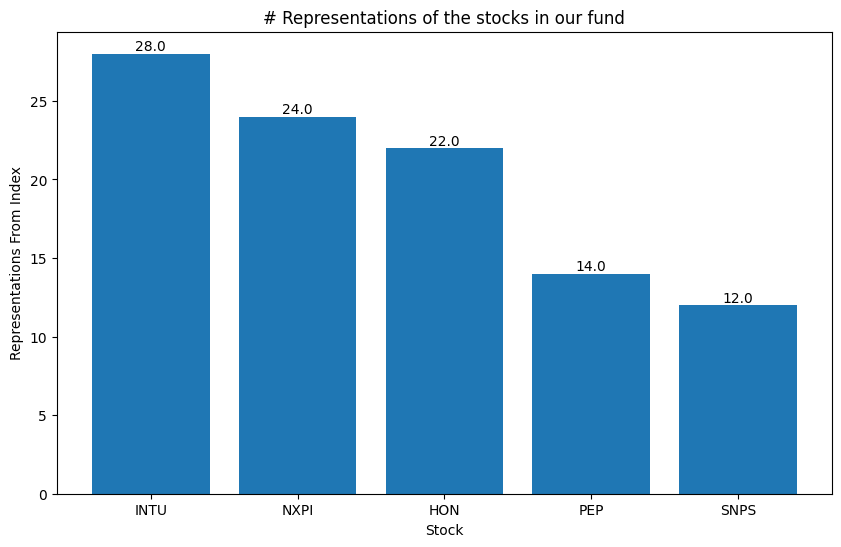

In [11]:
#Calulating the importance of selected stocks in the fund
linking_stocks_df = pd.DataFrame(linking_stocks.x.tolist())
linking_stocks_df.columns = correl_2023.columns
linkings_graph = linking_stocks_df.sum().sort_values(ascending=False).head(m)
linkings_graph = pd.DataFrame(linkings_graph).reset_index()
linkings_graph.columns = ['stock', 'representations_from_index']
display(linkings_graph)

# Plot the data as a bar graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
bars = plt.bar(linkings_graph['stock'], linkings_graph['representations_from_index'])
plt.xlabel('Stock')
plt.ylabel('Representations From Index')
plt.title('# Representations of the stocks in our fund')

# Add labels with values on top of the bars
for bar in bars:
    value = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, value, str(value), ha='center', va='bottom')

# Show the plot
plt.show()

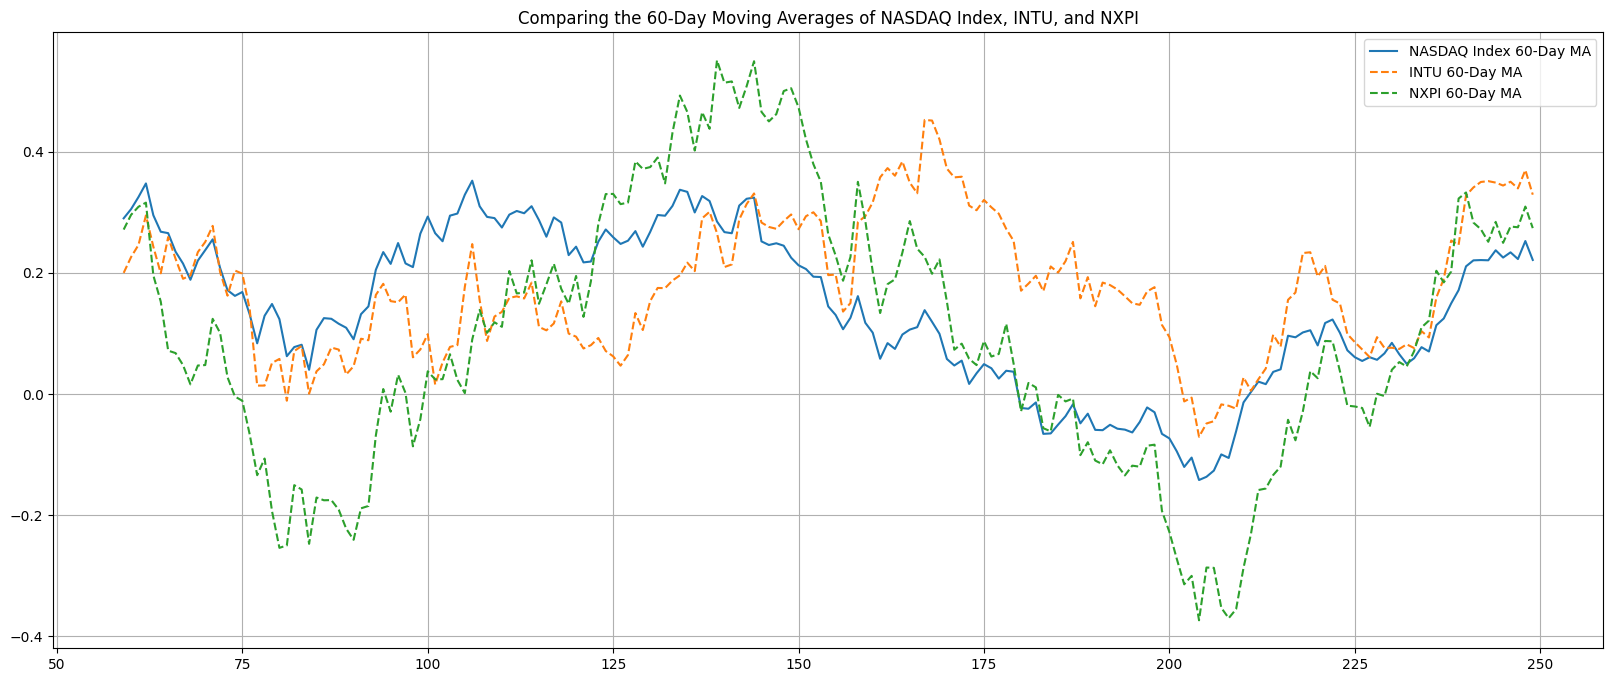

In [12]:
#Now lets see the performance comparision of the index and out 2 most similar stocks using 60 day moving average.
selected_stocks = returns_2023[selected_columns_list]


index_2023 = returns_2023['NDX']
#most similar stocks
first_stock = linkings_graph.loc[:1,'stock'].values[0]
second_stock = linkings_graph.loc[:1,'stock'].values[1]

# Calculate the 60-day moving average for the NASDAQ Index
moving_avg_index_2023 = index_2023.rolling(window=60).mean()

# Calculate the 60-day moving average for INTU
moving_avg_first_stock = selected_stocks[first_stock].rolling(window=60).mean()

# Calculate the 60-day moving average for NXPI
moving_avg_second_stock = selected_stocks[second_stock].rolling(window=60).mean()

# Create the main figure with one subplot
fig, ax = plt.subplots(figsize=(20, 8))

# Plot the 60-day moving averages for NASDAQ Index, INTU, and NXPI
ax.plot(moving_avg_index_2023*100, label='NASDAQ Index 60-Day MA', linestyle='-')
ax.plot(moving_avg_first_stock*100, label=first_stock+' 60-Day MA', linestyle='--')
ax.plot(moving_avg_second_stock*100, label=second_stock+' 60-Day MA', linestyle='--')

# Title and legend for the subplot
ax.set_title('Comparing the 60-Day Moving Averages of NASDAQ Index, '+first_stock+', and '+second_stock)
ax.legend()

# Add a grid
ax.grid(True)

# Show the plot
plt.show()

### Weights calculation

In [13]:
#Creating to model to assign weights to the selected stocks
#initializing model
portfolio = gp.Model()
#adding decision variables
portfolio_weights = portfolio.addMVar(5)
index_diff = portfolio.addMVar(days_2023)

#adding constraints
portfolio_weights_const = portfolio.addConstr(gp.quicksum(portfolio_weights[i] for i in range(m)) == 1)

mod_const_1 = portfolio.addConstrs(
    (gp.quicksum(portfolio_weights[i] * selected_stocks.iloc[j, i] for i in range(m)) - index_2023[j]) <= index_diff[j]
    for j in range(days_2023)
)

mod_const_2 = portfolio.addConstrs(
    (-1 * gp.quicksum(portfolio_weights[i] * selected_stocks.iloc[j, i] for i in range(m)) + index_2023[j]) <= index_diff[j]
    for j in range(days_2023)
)
portfolio.setObjective(gp.quicksum(index_diff[i] for i in range(days_2023)), sense=gp.GRB.MINIMIZE)
portfolio.Params.OutputFlag = 0
portfolio.optimize()


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


In [14]:
print('\n The difference between 2023 NASDAQ Index return and our fund return = ', round(portfolio.objval, 2), '\n \n', 'The weights assigned to stocks in our fund are -')

portfolio_weights_df = pd.DataFrame()
portfolio_weights_df['stock'] = selected_columns_list
portfolio_weights_df['weights'] = portfolio_weights.x.tolist()

portfolio_weights_df = portfolio_weights_df.sort_values('weights', ascending=False)
portfolio_weights_df


 The difference between 2023 NASDAQ Index return and our fund return =  1.11 
 
 The weights assigned to stocks in our fund are -


,stock,weights
4,SNPS,0.254780
1,INTU,0.227170
3,PEP,0.210777
2,NXPI,0.171944
0,HON,0.135328


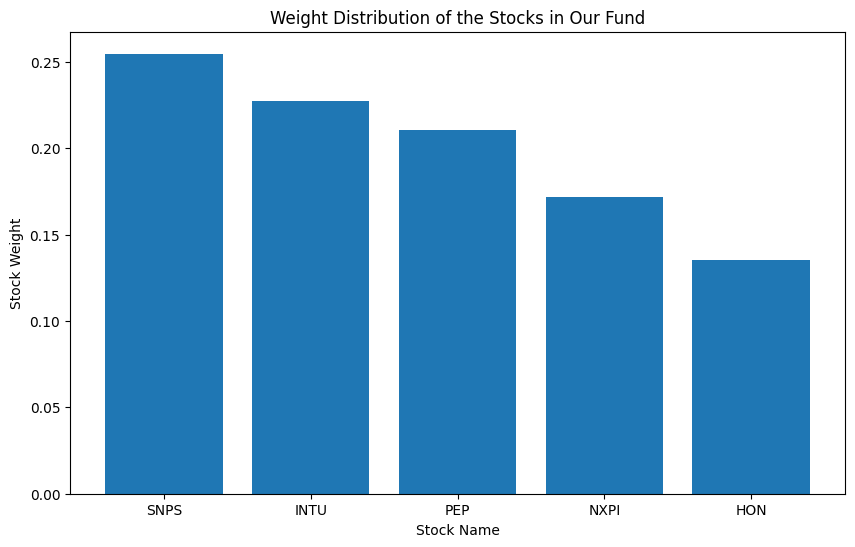

In [15]:
# Plotting a bar-grpah to see the weight distribution of our fund.
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
bars = plt.bar(portfolio_weights_df['stock'], portfolio_weights_df['weights'])
plt.xlabel('Stock Name')
plt.ylabel('Stock Weight')
plt.title('Weight Distribution of the Stocks in Our Fund')

# Show the plot
plt.show()

##### Analyzing the Fund's performance

In [16]:
returns_2024 = stocks_2024.copy()  # Create a copy of the original DataFrame
returns_2024.drop(columns=['Date'], inplace=True)  # Drop the 'Date' column if it exists
returns_2024 = returns_2024.pct_change()
returns_2024 = returns_2024.fillna(0)
index_2024 = returns_2024['NDX']

/var/folders/z_/pyggm69d0rnbpbpsfrrvw4m80000gn/T/ipykernel_7369/4230402196.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_2024 = returns_2024.pct_change()


In [17]:
# Now let's filter the 2024 return dataset for the selected stocks
fil_2024_returns = returns_2024[selected_columns_list]
weight_x = portfolio_weights_df['weights']
weighted_fil_2024_return = pd.DataFrame()
for i, col in enumerate(fil_2024_returns.columns):
    weighted_fil_2024_return[col] = fil_2024_returns[col] * weight_x[i]
weighted_fil_2024_return['total_returns_fund'] = weighted_fil_2024_return[selected_columns_list].sum(axis=1)
m_5_2024_error = sum(abs(returns_2024['NDX'] - weighted_fil_2024_return['total_returns_fund']))

print('\nThe difference between the 2023 NASDAQ Index and the fund we have created (Training error) = ', round(portfolio.objval, 2), '\n')

print('The difference between the 2024 NASDAQ Index and the fund we have created (Testing error) = ', round(m_5_2024_error, 2))


The difference between the 2023 NASDAQ Index and the fund we have created (Training error) =  1.11 

The difference between the 2024 NASDAQ Index and the fund we have created (Testing error) =  1.15


### itterating over different values of m

In [18]:
m_array = [5,10,20,30,40,50,60,70,80,90,100] 

In [19]:

selected_stock_dictionary = {}
weights_dictionary = {}
objective_selected_stock = []
for m in m_array:
    
    if n >= m:
    
        fund_creator = gp.Model() 
        selected_stocks = fund_creator.addMVar(100, vtype='B')  # Binary variable to flag the selected stocks
        linking_stocks = fund_creator.addMVar((100, 100), vtype='B')  # Binary variable to link stock in index to the fund

        selection_const = fund_creator.addConstr(gp.quicksum(selected_stocks[i] for i in range(n)) <= m)
        one_representative_const = fund_creator.addConstrs(gp.quicksum(linking_stocks[i, j] for j in range(n)) == 1 for i in range(n))
        ensure_best_representative_const = fund_creator.addConstrs(linking_stocks[i, j] <= selected_stocks[j] for j in range(n) for i in range(n))

        # Set the objective function using the calculated values
        fund_creator.setObjective(gp.quicksum(correl_2023.iloc[i, j] * linking_stocks[i, j] for i in range(n) for j in range(n)), sense=gp.GRB.MAXIMIZE)
        fund_creator.Params.OutputFlag = 0
        fund_creator.optimize()
        
        objective_selected_stock.append(fund_creator.objval)
        
        # Convert the array to a pandas Series for easier manipulation
        selection_series = pd.Series(selected_stocks.x)

        # Get the selected columns from returns_2023
        selected_columns = correl_2023.columns[selection_series == 1]
        selected_columns_list = selected_columns.tolist()
        print('\n M = ', m, ' | Selected Stocks = ', selected_columns_list, ' \n')
        selected_stock_dictionary[m] = selected_columns_list

        selected_stocks = returns_2023[selected_columns_list]
        index_2023 = returns_2023['NDX']

        portfolio = gp.Model()
        portfolio_weights = portfolio.addMVar(m)
        index_diff = portfolio.addMVar(days_2023)
        portfolio_weights_const = portfolio.addConstr(gp.quicksum(portfolio_weights[i] for i in range(m)) == 1)

        mod_const_1 = portfolio.addConstrs(
            (gp.quicksum(portfolio_weights[i] * selected_stocks.iloc[j, i] for i in range(m)) - index_2023[j]) <= index_diff[j]
            for j in range(days_2023)
        )
        mod_const_2 = portfolio.addConstrs(
            (-1 * gp.quicksum(portfolio_weights[i] * selected_stocks.iloc[j, i] for i in range(m)) + index_2023[j]) <= index_diff[j]
            for j in range(days_2023)
        )
        portfolio.setObjective(gp.quicksum(index_diff[i] for i in range(days_2023)), sense=gp.GRB.MINIMIZE)
        portfolio.Params.OutputFlag = 0
        portfolio.optimize()
        print('\n Portfolio Weights = ', portfolio_weights.x, ' \n')
        weights_dictionary[m] = portfolio_weights.x
    
    else:
        print('Error! Trying to select more stocks than present in the raw data!')



 M =  5  | Selected Stocks =  ['HON', 'INTU', 'NXPI', 'PEP', 'SNPS']  

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored

 Portfolio Weights =  [0.13532788 0.22717044 0.17194387 0.21077737 0.25478043]  


 M =  10  | Selected Stocks =  ['AMZN', 'AEP', 'BKR', 'CRWD', 'GILD', 'HON', 'IDXX', 'NXPI', 'PEP', 'SNPS']  

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored

 Portfolio Weights =  [0.23728998 0.02919945 0.02652856 0.04057024 0.06131693 0.04741088
 0.03932054 0.15933606 0.1652286  0.19379875]  


 M =  20  | Selected Stocks =  ['ABNB', 'AMZN', 'AEP', 'AMAT', 'ARM', 'AZN', 'ADP', 'CHTR', 'CRWD', 'DXCM', 'FANG', 'GILD', 'HON', 'IDXX', 'MRNA', 'NXPI', 'PEP', 'ROST', 'SNPS', 'TTWO']  

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored

 Portfolio Weights =  [0.01020436 0.22340635 0.02674762 0.07650599 0.01650352 0.0139473
 0.02821154 0.03734869 0.02923802 0.         0.0206361  0.02410016
 0.01248407 0

### Analyzing the Fund's performance across variation in m

In [20]:
# This code block calculates the training error - 2023 NASDAQ Index vs Fund

simple_errors_2023 = []

for m in m_array:
    # Now let's filter the 2023 return dataset for the selected stocks
    fil_2023_returns = returns_2023[selected_stock_dictionary[m]]
    weight_x = weights_dictionary[m].tolist()
    weighted_fil_2023_return = pd.DataFrame()
    for i, col in enumerate(fil_2023_returns.columns):
        weighted_fil_2023_return[col] = fil_2023_returns[col] * weight_x[i]
    weighted_fil_2023_return['total_returns_fund'] = weighted_fil_2023_return[selected_stock_dictionary[m]].sum(axis=1)
    simple_errors_2023.append(np.sum(abs(returns_2023['NDX'] - weighted_fil_2023_return['total_returns_fund'])))

/var/folders/z_/pyggm69d0rnbpbpsfrrvw4m80000gn/T/ipykernel_7369/1778634382.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weighted_fil_2023_return['total_returns_fund'] = weighted_fil_2023_return[selected_stock_dictionary[m]].sum(axis=1)


In [21]:
# This code block calculates the testing error - 2024 NASDAQ Index vs Fund

simple_errors_2024 = []

for m in m_array:
    # Now let's filter the 2024 return dataset for the selected stocks
    fil_2024_returns = returns_2024[selected_stock_dictionary[m]]
    weight_x = weights_dictionary[m].tolist()
    weighted_fil_2024_return = pd.DataFrame()
    for i, col in enumerate(fil_2024_returns.columns):
        weighted_fil_2024_return[col] = fil_2024_returns[col] * weight_x[i]
    weighted_fil_2024_return['total_returns_fund'] = weighted_fil_2024_return[selected_stock_dictionary[m]].sum(axis=1)
    # simple_errors_2024.append(sum(abs(returns_2024['NDX'] - weighted_fil_2024_return['total_returns_fund'])))
    #append average absolute error

    simple_errors_2024.append(np.sum(abs(returns_2024['NDX'] - weighted_fil_2024_return['total_returns_fund'])))

/var/folders/z_/pyggm69d0rnbpbpsfrrvw4m80000gn/T/ipykernel_7369/2172772697.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weighted_fil_2024_return['total_returns_fund'] = weighted_fil_2024_return[selected_stock_dictionary[m]].sum(axis=1)


In [22]:
simple_error_df = pd.DataFrame()
simple_error_df['selected_stocks'] = m_array
simple_error_df['stock_selection_objective'] = objective_selected_stock
simple_error_df['2023_errors'] = simple_errors_2023
simple_error_df['2024_errors'] = simple_errors_2024

simple_error_df.set_index('selected_stocks', inplace=True)
simple_error_df

,stock_selection_objective,2023_errors,2024_errors
selected_stocks,,,
5,51.445028,1.110995,1.149486
10,57.334558,0.892112,0.859961
20,65.187926,0.815582,0.744107
30,71.484965,0.721991,0.709045
40,77.237471,0.619039,0.736372
50,82.643246,0.476531,0.667335
60,87.473282,0.426184,0.716298
70,91.730926,0.288400,0.609647
80,95.478613,0.154236,0.474498


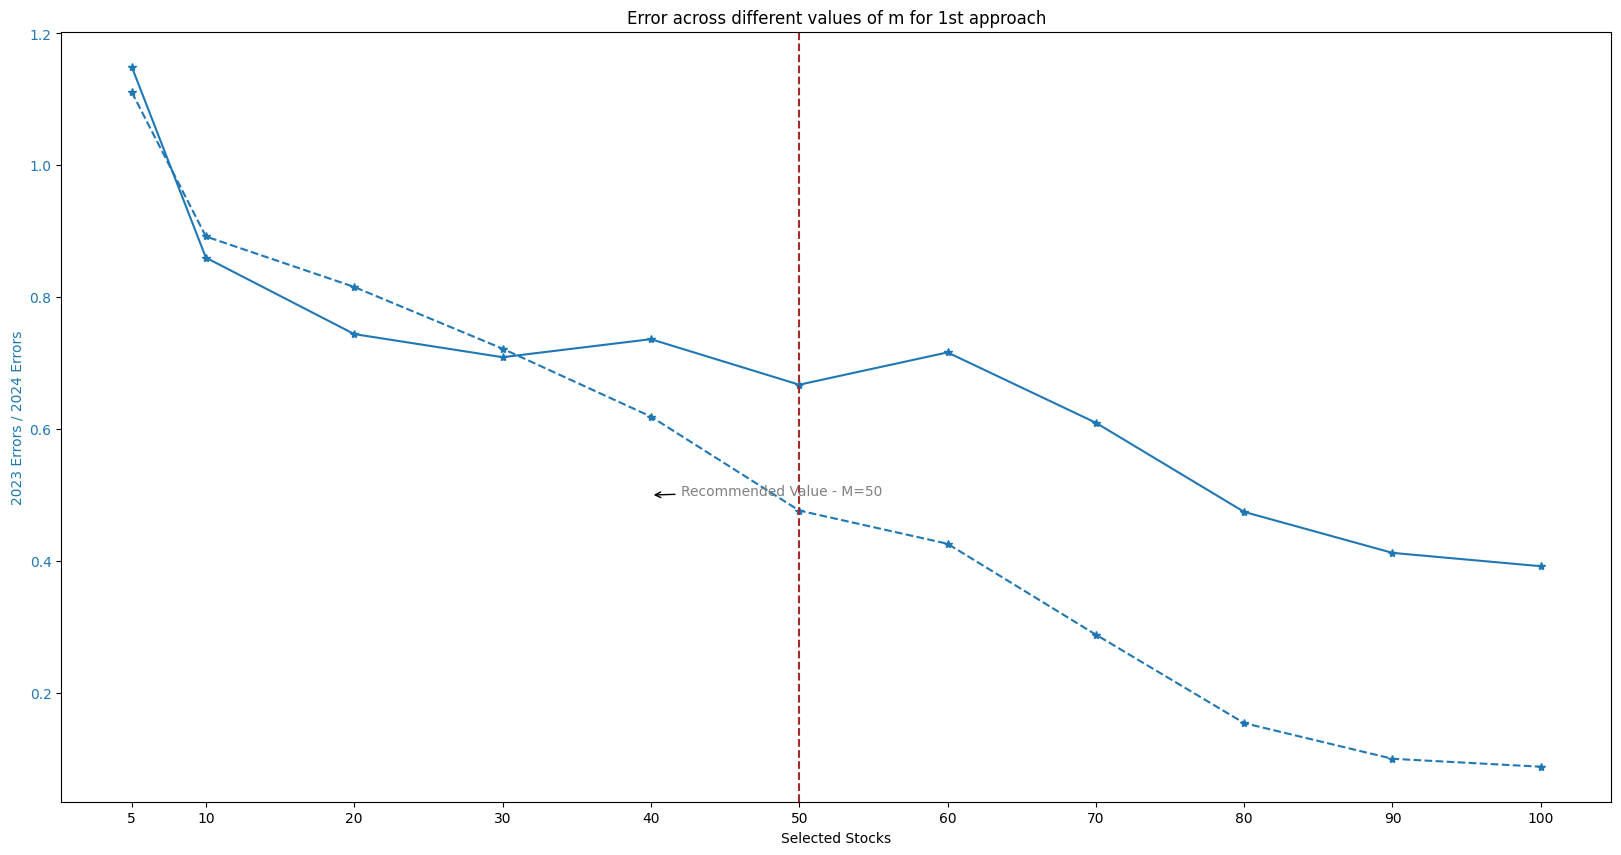

In [23]:
#Creating a line chart to compare Train vs Test Error.
# Create a figure and axis with increased figure size
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot the 2023 and 2024 errors on the primary y-axis with markers
ax1.set_xlabel('Selected Stocks')
ax1.set_ylabel('2023 Errors / 2024 Errors', color='tab:blue')
ax1.plot(simple_error_df['2023_errors'], label='2023 Errors', color='tab:blue', marker='*', linestyle='--')
ax1.plot(simple_error_df['2024_errors'], label='2024 Errors', color='tab:blue', marker='*')
ax1.tick_params(axis='y', labelcolor='tab:blue')


# Add a legend
lines, labels = ax1.get_legend_handles_labels()

# Set the x-axis labels
plt.xticks(simple_error_df.index)

# Add a dotted line at x=40 and label
ax1.axvline(x=50, color='brown', linestyle='--', label='Recommended Value - M=50')
ax1.annotate('Recommended Value - M=50', xy=(40, 0.5), xytext=(42, 0.5), color='gray', arrowprops=dict(arrowstyle='->'))

# Show the plot
plt.title('Error across different values of m for 1st approach')
plt.show()


As the value of m increases, the training error keeps going down but the testing error reduces till m=40 and then it starts to increase. 
**M= 40 would be the ideal value**

## Portfolio Construction- MIP Approach

In [31]:
#Creating Model and Calulating weights across different values of m
m_array = [5,10,20,30,40,50,60,70,80,90,100] #Define m values 
T = 3600 #Define the working time for gurobi for each m value (in sec)
M = 2 #Big M variable
stock_weight_dictionary_complex = {}
selected_stock_dictionary_complex = {}

for m in m_array:
    
    if n >= m:
        complex_model = gp.Model()
        select_stock = complex_model.addMVar(n, vtype='B')
        stock_weight = complex_model.addMVar(n)
        index_difference = complex_model.addMVar(days_2023)

        selection_const_complex = complex_model.addConstr(gp.quicksum(select_stock[i] for i in range(n)) == m)
        portfolio_weights_const_complex = complex_model.addConstr(gp.quicksum(stock_weight[i] for i in range(n)) == 1)

        mod_const_1_complex = complex_model.addConstrs(
            (gp.quicksum(stock_weight[i] * returns_2023.iloc[j, i + 1] for i in range(n)) - index_2023[j]) <= index_difference[j]
            for j in range(days_2023)
        )

        mod_const_2 = complex_model.addConstrs(
            (-1 * gp.quicksum(stock_weight[i] * returns_2023.iloc[j, i + 1] for i in range(n)) + index_2023[j]) <= index_difference[j]
            for j in range(days_2023)
        )

        big_m_const = complex_model.addConstrs(stock_weight[i] <= select_stock[i] * M for i in range(n))

        complex_model.setObjective(gp.quicksum(index_difference[i] for i in range(days_2023)), sense=gp.GRB.MINIMIZE)
        complex_model.setParam(gp.GRB.Param.TimeLimit, T)
        complex_model.Params.OutputFlag = 0
        complex_model.optimize()
        selected_stock_dictionary_complex[m] = select_stock.x
        stock_weight_dictionary_complex[m] = stock_weight.x


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter TimeLimit to value 3600
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter TimeLimit to value 3600
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter TimeLimit to value 3600
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter TimeLimit to value 3600
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter TimeLimit to value 3600
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter TimeLimit to value 3600
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter TimeLimit to value 3600
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter TimeLimit to value 3600
Warning for adding constraints: zero or small (< 1e-13) coefficients, ig

In [33]:
#Convert dictionary to a DataFrame 
stock_weight_dictionary_complex_df = pd.DataFrame(stock_weight_dictionary_complex)

In [34]:
# Convert the DataFrame to CSV
stock_weight_dictionary_complex_df.to_csv('stock_weight_dictionary_complex.csv', index=False)

# Provide a download link within Jupyter Notebook
from IPython.display import FileLink
FileLink('stock_weight_dictionary_complex.csv')

/Users/rony/Documents/UT Austin/Fall Sem/optimization/hw/group projects/gp2/stock_weight_dictionary_complex.csv

In [35]:
##Convert dictionary to a DataFrame 
selected_stock_dictionary_complex_df = pd.DataFrame(selected_stock_dictionary_complex)

In [36]:
# Convert the DataFrame to CSV
selected_stock_dictionary_complex_df.to_csv('selected_stock_dictionary_complex.csv', index=False)

# Provide a download link within Jupyter Notebook
from IPython.display import FileLink
FileLink('selected_stock_dictionary_complex.csv')

/Users/rony/Documents/UT Austin/Fall Sem/optimization/hw/group projects/gp2/selected_stock_dictionary_complex.csv

### Analyzing the Fund's performance across variation in m

In [24]:
#Reading the weight and selected stocks CSVs into a DF.
stock_weight_complex_df = pd.read_csv(r"stock_weight_dictionary_complex.csv")
selected_stock_complex_df = pd.read_csv(r"selected_stock_dictionary_complex.csv")

In [25]:
selected_stock_dictionary_names_complex = {}

returns_2024_x = returns_2024.drop(columns=['NDX'])
for m in m_array:
    # Convert the array to a pandas Series for easier manipulation
    selection_series = pd.Series(selected_stock_complex_df[str(m)])

    # Get the selected columns from returns_2024
    selected_columns = returns_2024_x.columns[selection_series == 1]
    selected_columns_list = selected_columns.tolist()
    selected_stock_dictionary_names_complex[m] = selected_columns_list

In [26]:
returns_2023_x = returns_2023.drop(columns=['NDX'])
returns_2024_x = returns_2024.drop(columns=['NDX'])

In [27]:
#Calculating the Training Error for MIP Approach.
complex_errors_2023 = []

for m in m_array:
    weight_x = stock_weight_complex_df[str(m)]
    weighted_fil_2023_return = pd.DataFrame()
    for i, col in enumerate(returns_2023_x.columns):
        weighted_fil_2023_return[col] = returns_2023_x[col] * weight_x[i]
    
    weighted_fil_2023_return['total_returns_fund'] = weighted_fil_2023_return[selected_stock_dictionary_names_complex[m]].sum(axis=1)
    complex_errors_2023.append(np.sum(abs(index_2023 - weighted_fil_2023_return['total_returns_fund'])))

/var/folders/z_/pyggm69d0rnbpbpsfrrvw4m80000gn/T/ipykernel_7369/1873867490.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weighted_fil_2023_return['total_returns_fund'] = weighted_fil_2023_return[selected_stock_dictionary_names_complex[m]].sum(axis=1)
/var/folders/z_/pyggm69d0rnbpbpsfrrvw4m80000gn/T/ipykernel_7369/1873867490.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weighted_fil_2023_return['total_returns_fund'] = weighted_fil_2023_return[selected_stock_dictionary_names_complex[m]].sum(axis=1)
/var/folders/z_/py

In [28]:
#Calculating the Testing Error for MIP Approach.
complex_errors_2024 = []

for m in m_array:
    weight_x = stock_weight_complex_df[str(m)]
    weighted_fil_2024_return = pd.DataFrame()
    for i, col in enumerate(returns_2024_x.columns):
        weighted_fil_2024_return[col] = returns_2024_x[col] * weight_x[i]
    
    weighted_fil_2024_return['total_returns_fund'] = weighted_fil_2024_return[selected_stock_dictionary_names_complex[m]].sum(axis=1)
    complex_errors_2024.append(np.sum(abs(returns_2024['NDX'] - weighted_fil_2024_return['total_returns_fund'])))

/var/folders/z_/pyggm69d0rnbpbpsfrrvw4m80000gn/T/ipykernel_7369/2826230865.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weighted_fil_2024_return['total_returns_fund'] = weighted_fil_2024_return[selected_stock_dictionary_names_complex[m]].sum(axis=1)
/var/folders/z_/pyggm69d0rnbpbpsfrrvw4m80000gn/T/ipykernel_7369/2826230865.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weighted_fil_2024_return['total_returns_fund'] = weighted_fil_2024_return[selected_stock_dictionary_names_complex[m]].sum(axis=1)
/var/folders/z_/py

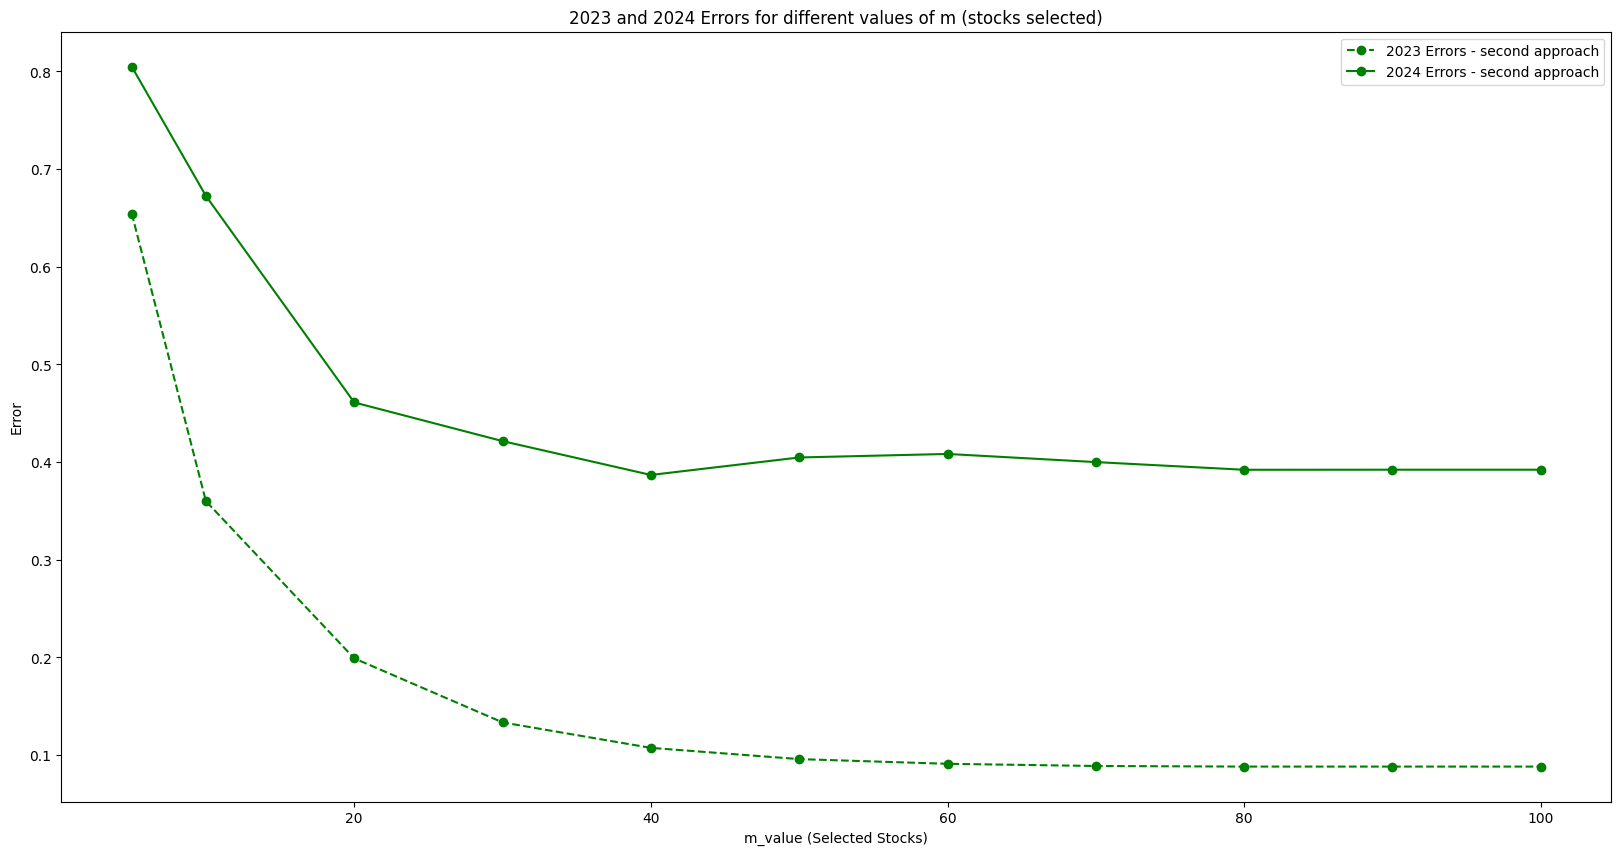

In [29]:
#Plotting Training and Testing Errors Vs Diffenrt M Values
complex_errors_df = pd.DataFrame()
complex_errors_df['2023_errors_complex'] = complex_errors_2023
complex_errors_df['2024_errors_complex'] = complex_errors_2024
complex_errors_df['m_value'] = m_array

plt.figure(figsize=(20, 10))

# Plotting 2023 and 2024 errors with 'm_value' as the x-axis
plt.plot(complex_errors_df['m_value'], complex_errors_df['2023_errors_complex'], label='2023 Errors - second approach', marker='o', color='green', linestyle='--')
plt.plot(complex_errors_df['m_value'], complex_errors_df['2024_errors_complex'], label='2024 Errors - second approach', marker='o', color='green')

# Add a legend
plt.legend()

# Add labels and title
plt.xlabel('m_value (Selected Stocks)')
plt.ylabel('Error')
plt.title('2023 and 2024 Errors for different values of m (stocks selected)')
plt.show()


,stock_selection_objective,2023_errors,2024_errors,2023_errors_complex,2024_errors_complex
selected_stocks,,,,,
5,51.445028,1.110995,1.149486,0.654442,0.804923
10,57.334558,0.892112,0.859961,0.359938,0.672515
20,65.187926,0.815582,0.744107,0.198931,0.461004
30,71.484965,0.721991,0.709045,0.133374,0.421407
40,77.237471,0.619039,0.736372,0.107275,0.386741
50,82.643246,0.476531,0.667335,0.095768,0.404643
60,87.473282,0.426184,0.716298,0.090961,0.408253
70,91.730926,0.288400,0.609647,0.088713,0.399921
80,95.478613,0.154236,0.474498,0.088113,0.392056


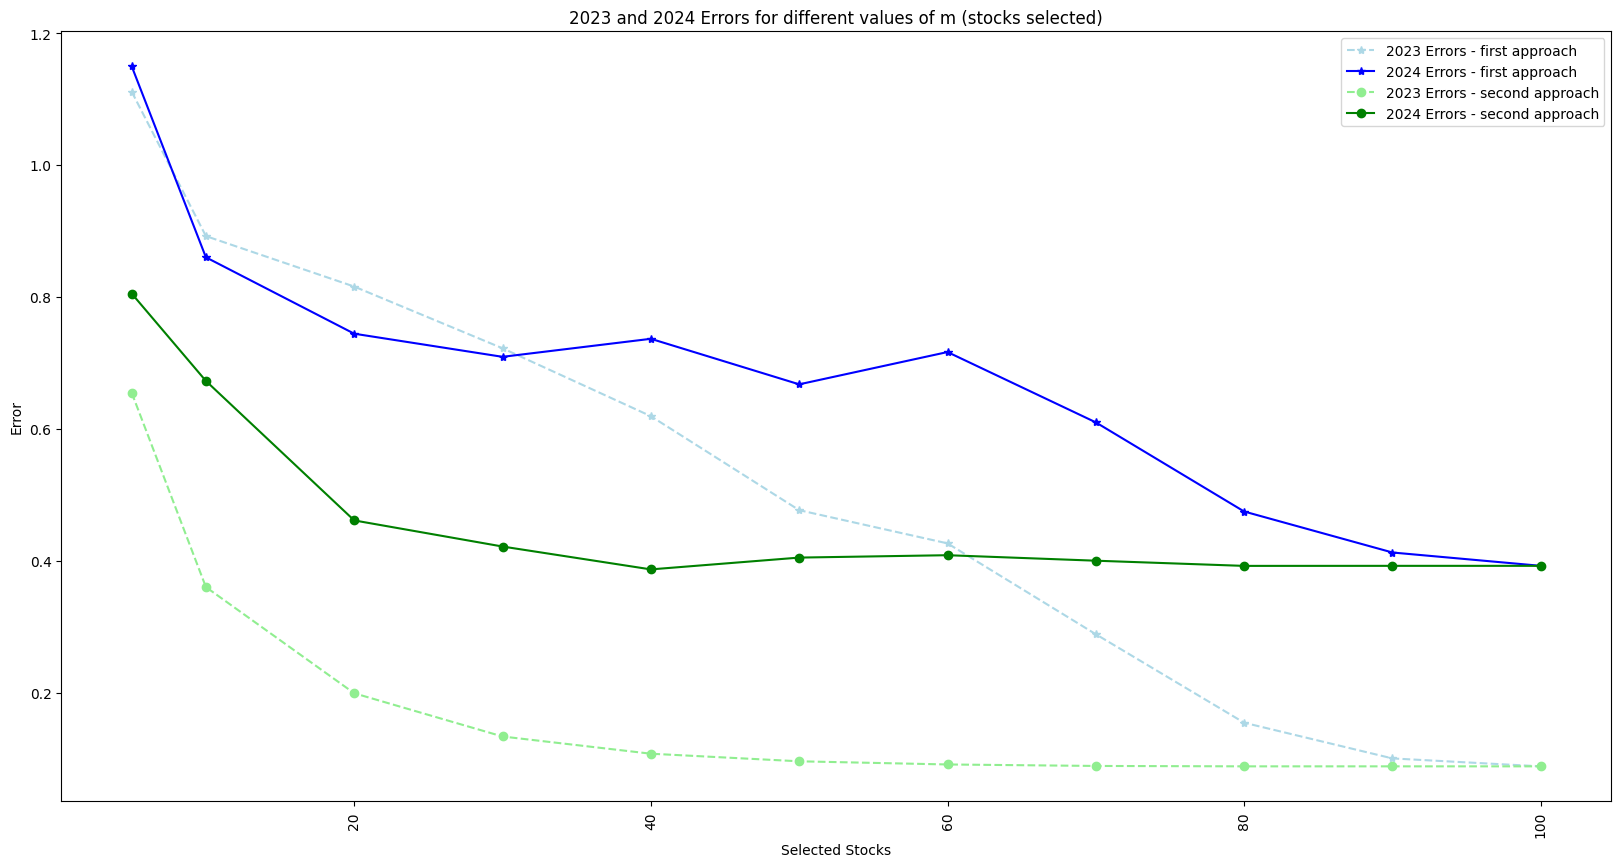

In [30]:
#Comparing the results from our first approach ( based on correlation ) and second approach ( minimizing index returns difference) for stock selection
combined_df = simple_error_df.reset_index()

combined_df['2023_errors_complex'] = complex_errors_df['2023_errors_complex']
combined_df['2024_errors_complex'] = complex_errors_df['2024_errors_complex']
combined_df.set_index('selected_stocks', inplace=True)
display(combined_df)

# Create a figure and set its size
plt.figure(figsize=(20, 10))

# Create a line chart for 2023 and 2024 errors
plt.plot(combined_df['2023_errors'], label='2023 Errors - first approach', marker='*', color='lightblue', linestyle='--')
plt.plot(combined_df['2024_errors'], label='2024 Errors - first approach', marker='*', color='blue')

plt.plot(combined_df['2023_errors_complex'], label='2023 Errors - second approach', marker='o', color='lightgreen', linestyle='--')
plt.plot(combined_df['2024_errors_complex'], label='2024 Errors - second approach', marker='o', color='green')

# Add labels and title
plt.xlabel('Selected Stocks')
plt.ylabel('Error')
plt.title('2023 and 2024 Errors for different values of m (stocks selected)')

# Add a legend
plt.legend()


# Show all x-axis values
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees

plt.show()